In [1]:
from butterflow import lex, Parser, TypeChecker, Builder, Runtime
import numpy as np
from glob import glob
import json
from datetime import datetime, timedelta
import pandas as pd
from rhetenor import data
from rhetenor.util import chart
from rhetenor.backtest import s3_to_df, initialize_runtime, compute, Bars, Position, CloseBacktester, overnight_synthetic_bar
from rhetenor.stat import calculate_stat
import pandas as pd 
import mplfinance as mpf
import pandas as pd 
from rhetenor.data import download_master

a = download_master()
df_univ = pd.DataFrame(a).T
df_kospi50 = df_univ.query("kospi50 == 'Y'")

SILENT = True
TIMEOUT= True
DELAY = 1 # Use T data, Position calculated at T+1
SIM_INTERVAL = timedelta(minutes=10)
s3_cfgs = {"auth_config_path": "../auth/aws_rhetenor.yaml"}
s3 = data.S3KlineWrapper(exchange_code="UN", bucket="rhetenor", **s3_cfgs)
day_start = datetime.combine(datetime.now().date(), datetime.min.time())
s3.load(datetime_from=datetime.now()-timedelta(days=20), datetime_to=day_start)


/nix/store/ijcmgn92i7q128lir59icyrj8xrgjgn5-python3-3.13.9-env/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'new.real.download.dws.co.kr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


S3KlineWrapper loaded 6545 records.


In [2]:
import random 
instr = random.choice(df_kospi50.index)

s3_df, s3_dfs = s3_to_df(s3)
dfs_synth = overnight_synthetic_bar(s3_dfs)
data = pd.DataFrame({k:v[instr] for k,v in dfs_synth.items()})
data["returns"] = 0
data["Position"] = 0
chart(data)

<Axes: ylabel='Frequency'>

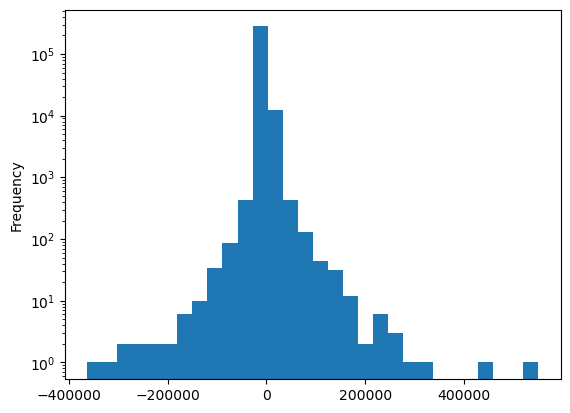

In [3]:
# Initialize runtime
runtime = initialize_runtime(dfs=s3_dfs, check_corruption=True)
bars = Bars(data=s3_df, interval=SIM_INTERVAL)

# Calculate Technical Indicator
with open("technical_indicators/adl.bf", "rt") as f:
    input_code = f.read()
input_code = """
open = data(id="open")
high = data(id="high")
low = data(id="low")
close = data(id="close")
volume = data(id="volume")
""" + input_code + """
result = adl(high=high, low=low, close=close, volume=volume, period=5) 
"""
position_input = compute(runtime, input_code, silent=SILENT)
pd.Series(position_input.ravel()).plot.hist(bins=30, logy=True)

In [16]:
position = Position(
    data=pd.DataFrame(
        position_input, index=s3_dfs["close"].index, columns=s3_dfs["close"].columns
        ).shift(DELAY).clip(-10000, 10000).ewm(halflife=60).mean().multiply(-1),
        interval=SIM_INTERVAL
    )
backtester = CloseBacktester(data=bars, fee=0.1 * 0.01) # TODO: exclude overnight return
df_results, pos_nanfilled, pos_zerofilled, pos_actual = backtester.run(position)

import random 
instr = random.choice(df_kospi50.index)
data = bars.data[instr].unstack()
data['Position'] = pos_zerofilled.data[instr]
data["returns"] = df_results["ret"]
chart(data)

/home/jongkook90/community_financial_text/ui/rhetenor/notebooks/rhetenor/backtest.py:190: RuntimeWarning:

Mean of empty slice

